# Homework 3b

In [1]:
# imports
import gym
import my_acrobot
import numpy as np
import matplotlib.pyplot as plt
from dqn import DQN
from dqn import Transition
from dqn import ReplayMemory
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# set default tensor type to Double
torch.set_default_tensor_type(torch.DoubleTensor)

# initialize env and net agents
env = gym.make('MyAcrobot-v0')

in_channels = env.observation_space.n
out_channels = env.action_space.n
batch_size = 64
reward_decay = .99
eps_start = 1.
eps_end = .01
target_update = 10
device = "cpu"

policy_net = DQN(in_channels, out_channels, batch_size, reward_decay, eps_start=1., eps_end=.01).to(device)
target_net = DQN(in_channels, out_channels, batch_size, reward_decay, eps_start=1., eps_end=.01).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


def optimize_model():
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for detailed explanation.)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])
    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * reward_decay) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


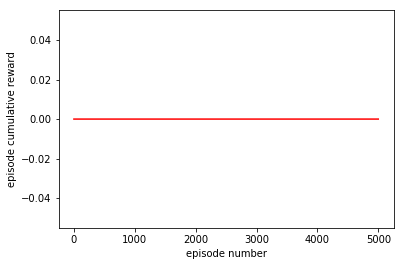

In [4]:
num_episodes = 5000
max_time = 100
all_cum_rewards = np.array(0)
for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = torch.tensor(env.reset(), device=device)
    episode_cum_reward = 0
    for t in range(max_time):
        # Select and perform an action
        action = policy_net.select_action(state)
        next_state, reward, done, info = env.step(action.item())
        # state = torch.tensor(state, device=device)
        # action = torch.tensor([action], device=device)
        next_state = torch.tensor(next_state, device=device)
        reward = torch.tensor([reward], device=device)
        episode_cum_reward += reward
        if done:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()

    # Update the target network
    if i_episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    all_cum_rewards = np.append(all_cum_rewards, episode_cum_reward)
    
all_cum_rewards = all_cum_rewards[0:-1]
plt.plot(range(num_episodes), all_cum_rewards, 'r')
plt.ylabel('episode cumulative reward')
plt.xlabel('episode number')
plt.show()


Even with a delta of pi/4 the agent never finds any reward. I'm going to try to adjust batch size and torque magnitude next.